In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
def wrong_pred(y_test, y_pred):
    '''
    This function reads the actual class and predictions
    and outputs the sample number, the actual class and the prediction
    of the missclassified samples
    '''
    x_wrong = []
    y_wrong = []
    for i in range(len(y_test)):
        y_t = y_test[i]
        y_p = y_pred[i]
        if y_t != y_p:
            x_wrong.append(i)
            y_wrong.append(y_pred)
            print('sample #', i, 'predicted', y_p, 'when test is', y_t)
    return i, x_wrong, y_wrong  

In [3]:
# Unpickle data
data = pd.read_pickle('data')

In [4]:
# Separate target and features
target = 'diagnosis'
y = data[target]
X = data.drop(columns=[target])
#features_DT_list = ['texture_mean', 'area_worst', 'smoothness_worst', 'area_mean', 'concavity_mean']
features_DT_list = ['texture_mean', 'area_worst', 'smoothness_worst', 'concavity_mean']
X = X[features_DT_list]

In [5]:
# Encode the target
y = data[target]
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [7]:
# LOGISTIC REGRESSION

clfs = {'lr': LogisticRegression(random_state=0)}

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

param_grids = {}

# Parameter grid for Logistic Regression
C_range = [10]

param_grid = [{'clf__multi_class': ['ovr'], 'clf__solver': ['newton-cg'], 'clf__C': C_range}]

param_grids['lr'] = param_grid

gs = GridSearchCV(estimator=pipe_clfs['lr'], param_grid=param_grids['lr'], scoring='accuracy', n_jobs=1, iid=False, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=0))


In [8]:
# Fit
gs_lr = gs.fit(X_train, y_train)

In [9]:
# Get prediction
y_pred = gs_lr.predict(X_test)

In [10]:
# Get metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC_AUC Score', roc_auc_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.9824561403508771
ROC_AUC Score 0.9782608695652174
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.96      0.98        69

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



In [11]:
# Obtain the confusion matrix, LR model
LR_cm = confusion_matrix(y_test, y_pred)

In [12]:
tn, fp, fn, tp = LR_cm.ravel()
print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

tn 102 fp 0 fn 3 tp 66


[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

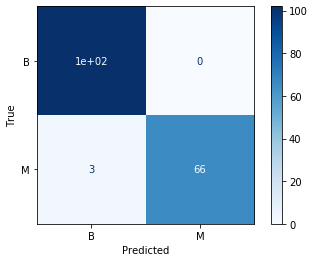

In [13]:
# Visualize the confusion matrix, non-normalized
LR_cmd = ConfusionMatrixDisplay(LR_cm, display_labels=['B','M'])
LR_cmd.plot(cmap='Blues')
LR_cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [14]:
i, lr_x_wrong, lr_y_wrong = wrong_pred(y_test, y_pred)

sample # 8 predicted 0 when test is 1
sample # 50 predicted 0 when test is 1
sample # 135 predicted 0 when test is 1


In [15]:
# RANDOM FOREST
clfs = {'rf': RandomForestClassifier(random_state=0)}

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()),
                                ('clf', clf)])

param_grids = {}

# Parameter grid for Random Forest
param_grid = [{'clf__max_depth': [5],
                'clf__n_estimators': [100],
               'clf__min_samples_split': [2],
               'clf__min_samples_leaf': [5]}]

param_grids['rf'] = param_grid

gs = GridSearchCV(estimator=pipe_clfs['rf'], param_grid=param_grids['rf'], scoring='accuracy', n_jobs=1, iid=False, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=0))


In [16]:
# Fit
gs_rf = gs.fit(X_train, y_train)

In [17]:
# Get prediction
y_pred = gs_rf.predict(X_test)

In [18]:
# Get metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC_AUC Score', roc_auc_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.9649122807017544
ROC_AUC Score 0.9612105711849958
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           1       0.97      0.94      0.96        69

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



In [19]:
# Obtain the confusion matrix, LR model
LR_cm = confusion_matrix(y_test, y_pred)

In [20]:
tn, fp, fn, tp = LR_cm.ravel()
print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

tn 100 fp 2 fn 4 tp 65


[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

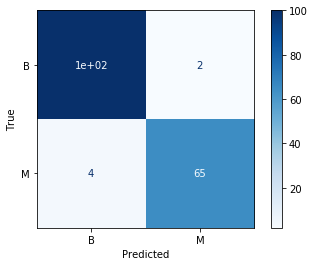

In [21]:
# Visualize the confusion matrix, non-normalized
LR_cmd = ConfusionMatrixDisplay(LR_cm, display_labels=['B','M'])
LR_cmd.plot(cmap='Blues')
LR_cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [22]:
i, rf_x_wrong, rf_y_wrong = wrong_pred(y_test, y_pred)

sample # 8 predicted 0 when test is 1
sample # 20 predicted 1 when test is 0
sample # 50 predicted 0 when test is 1
sample # 57 predicted 0 when test is 1
sample # 127 predicted 1 when test is 0
sample # 146 predicted 0 when test is 1


In [23]:
# ENSEMBLING

In [24]:
# 1- Voting

In [25]:
voting_clf = VotingClassifier(
    estimators=[('lr', gs_lr), ('rf', gs_rf)],
    voting='soft')

In [26]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
                                           error_score=nan,
                                           estimator=Pipeline(memory=None,
                                                              steps=[('StandardScaler',
                                                                      StandardScaler(copy=True,
                                                                                     with_mean=True,
                                                                                     with_std=True)),
                                                                     ('clf',
                                                                      LogisticRegression(C=1.0,
                                                                                         class_weight=None,
                                                       

In [27]:
from sklearn.metrics import accuracy_score

for clf in (gs_lr, gs_rf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

GridSearchCV 0.9824561403508771
GridSearchCV 0.9649122807017544
VotingClassifier 0.9766081871345029


In [28]:
roc_auc_score(y_test, y_pred)

0.9733589087809037

In [29]:
cm = confusion_matrix(y_test, y_pred)

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

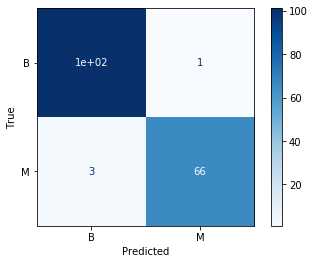

In [30]:
# Confusion matrix, non-normalized
cmd = ConfusionMatrixDisplay(cm, display_labels=['B','M'])
cmd.plot(cmap='Blues')
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [31]:
# 2- Stacking

In [32]:
estimators=[('lr', gs_lr), ('rf', gs_rf)]

In [33]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [34]:
stacking_clf.fit(X_train, y_train).score(X_test, y_test)

0.9824561403508771

In [35]:
roc_auc_score(y_test, y_pred)

0.9733589087809037

In [36]:
cm = confusion_matrix(y_test, y_pred)

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

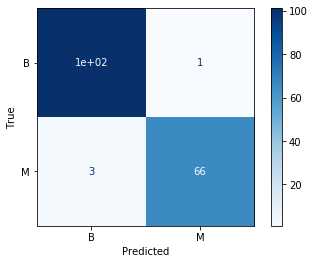

In [37]:
# Confusion matrix, non-normalized
cmd = ConfusionMatrixDisplay(cm, display_labels=['B','M'])
cmd.plot(cmap='Blues')
cmd.ax_.set(xlabel='Predicted', ylabel='True')